In [11]:
from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import wfdb
from pathlib import Path
import os

In [12]:
file_path = Path('C:/Users/vinay/Downloads/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0')
file_name = '100'
file = os.path.join(file_path, file_name)

In [17]:
signal, field = wfdb.rdsamp(file)
field

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}

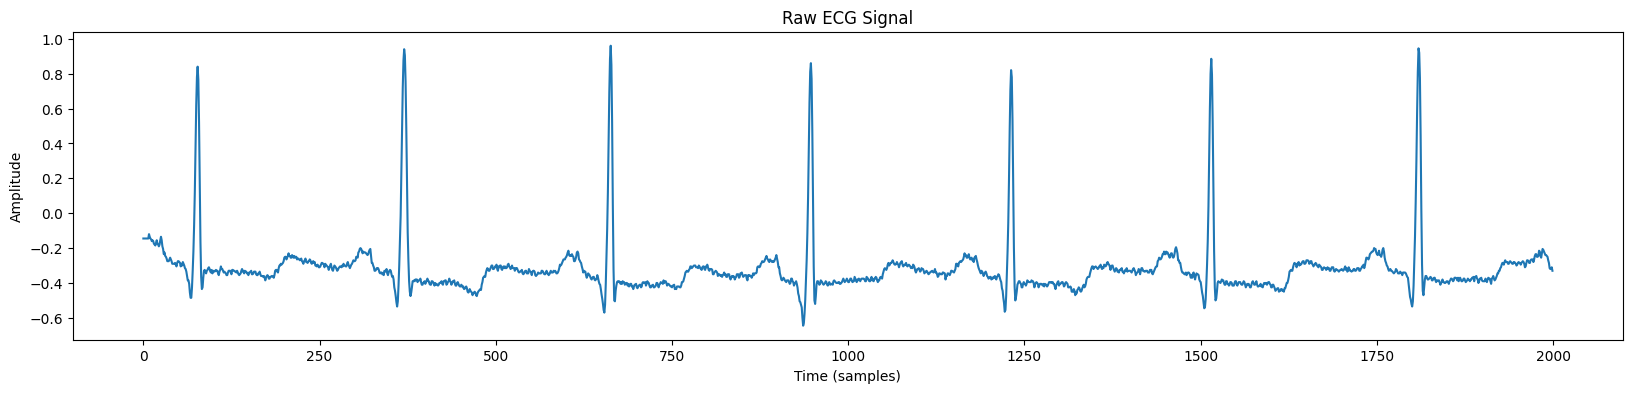

In [25]:
plt.figure(figsize=(20, 4))
plt.plot(signal[:2000, 0])  # Plot the first channel
plt.title('Raw ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
fs = 360
lowcut = 0.5
highcut = 45
nyquist = 0.5 * fs  # Nyquist frequency
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order=4, [low, high], btype='band')
y = filtfilt(b, a, data)